In [1]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import os.path as osp
sys.path.append(os.path.abspath('./'))
from data.pointcloud_dataset import load_one_class_under_folder
from trainers.point_net_vae import PointNetVariationalAutoEncoder
from trainers.autoencoder import default_train_params, Configuration
from models.vae_models import mlp_architecture_ala_iclr_18
from utils.dirs import create_dir
from utils.tf import reset_tf_graph
from utils.utils import plot_3d_point_cloud

Instructions for updating:
Colocations handled automatically by placer.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
class_name = 'chair'
data_root = '../latent_3d_points/data/shape_net_core_uniform_samples_2048/'
train_root = './experiments'
experiment_name = 'single_class_vae_test_summary'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'

In [4]:
pc_dataset = load_one_class_under_folder(data_root, class_name, verbose=True)

6778 pclouds were loaded. They belong in 1 shape-classes.


In [5]:
train_params = default_train_params()
train_params['batch_size'] = 400

In [6]:
print(train_params)

{'batch_size': 400, 'training_epochs': 500, 'denoising': False, 'learning_rate': 0.0005, 'z_rotate': False, 'saver_step': 10, 'loss_display_step': 1}


In [7]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = osp.join(train_root, experiment_name)
create_dir(osp.join(train_root, experiment_name))

0

In [8]:
conf = Configuration(n_input = [n_pc_points, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

In [9]:
load_pre_trained_ae = False
restore_epoch = 500
if load_pre_trained_ae:
    conf = Configuration.load(train_dir + '/configuration')
    reset_tf_graph()
    vae = PointNetVariationalAutoEncoder(conf.experiment_name, conf)
    vae.restore_model(conf.train_dir, epoch=restore_epoch)

In [10]:
print(conf)

                    batch_size: 400
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'layer_sizes': [256, 256, 6144], 'b_norm': False, 'b_norm_finish': False, 'verbose': True}
                       encoder: variational_encoder_with_convs_and_symmetry
                  encoder_args: {'n_filters': [64, 128, 128, 256, 128], 'filter_sizes': [1], 'strides': [1], 'b_norm': True, 'verbose': True}
               experiment_name: single_class_vae_test_summary
                 gauss_augment: None
                 held_out_step: 5
                  is_denoising: False
               latent_vs_recon: 0.01
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
             loss_summary_step: 10
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             save

In [11]:
reset_tf_graph()
vae = PointNetVariationalAutoEncoder(conf.experiment_name, conf)

Building Encoder
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
encoder_conv_layer_0 conv params =  256 bnorm params =  128
Tensor("single_class_vae_test_summary_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320 bnorm params =  256
Tensor("single_class_vae_test_summary_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512 bnorm params =  256
Tensor("single_class_vae_test_summary_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024 bnorm params =  512
Tensor("single_class_vae_test_summary_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896 bnorm params =  256
Tensor("single_class_vae_test_summary_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

enc

In [12]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = vae.train(pc_dataset, conf, log_file=fout)
fout.close()

Epoch: 0001 training time (minutes)= 0.1916 loss= 7.837500811
INFO:tensorflow:./experiments/single_class_vae_test_summary/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0002 training time (minutes)= 0.1466 loss= 3.091371328
Epoch: 0003 training time (minutes)= 0.1467 loss= 1.978114963
Epoch: 0004 training time (minutes)= 0.1475 loss= 1.454774797
Epoch: 0005 training time (minutes)= 0.1485 loss= 1.151487745
Epoch: 0006 training time (minutes)= 0.1479 loss= 0.953286793
Epoch: 0007 training time (minutes)= 0.1477 loss= 0.811655033
Epoch: 0008 training time (minutes)= 0.1482 loss= 0.705809403
Epoch: 0009 training time (minutes)= 0.1496 loss= 0.622832164
Epoch: 0010 training time (minutes)= 0.1475 loss= 0.556542229
INFO:tensorflow:./experiments/single_class_vae_test_summary/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0011 training time (minutes)= 0.1470 loss= 0.502346892
Epoch: 0012 training time (minutes)= 0.1474 loss= 0.4

Epoch: 0110 training time (minutes)= 0.1461 loss= 0.009792217
INFO:tensorflow:./experiments/single_class_vae_test_summary/models.ckpt-110 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0111 training time (minutes)= 0.1461 loss= 0.009612761
Epoch: 0112 training time (minutes)= 0.1472 loss= 0.009417799
Epoch: 0113 training time (minutes)= 0.1473 loss= 0.009236273
Epoch: 0114 training time (minutes)= 0.1461 loss= 0.008990355
Epoch: 0115 training time (minutes)= 0.1465 loss= 0.008852126
Epoch: 0116 training time (minutes)= 0.1472 loss= 0.008716113
Epoch: 0117 training time (minutes)= 0.1460 loss= 0.008525032
Epoch: 0118 training time (minutes)= 0.1474 loss= 0.008356743
Epoch: 0119 training time (minutes)= 0.1472 loss= 0.008235940
Epoch: 0120 training time (minutes)= 0.1468 loss= 0.008102264
INFO:tensorflow:./experiments/single_class_vae_test_summary/models.ckpt-120 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0121 training time (minutes)= 0.1466 loss= 

Epoch: 0219 training time (minutes)= 0.1471 loss= 0.003781892
Epoch: 0220 training time (minutes)= 0.1462 loss= 0.003793763
INFO:tensorflow:./experiments/single_class_vae_test_summary/models.ckpt-220 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0221 training time (minutes)= 0.1472 loss= 0.003785137
Epoch: 0222 training time (minutes)= 0.1464 loss= 0.003766306
Epoch: 0223 training time (minutes)= 0.1467 loss= 0.003766520
Epoch: 0224 training time (minutes)= 0.1465 loss= 0.003746874
Epoch: 0225 training time (minutes)= 0.1462 loss= 0.003755748
Epoch: 0226 training time (minutes)= 0.1461 loss= 0.003742191
Epoch: 0227 training time (minutes)= 0.1462 loss= 0.003754515
Epoch: 0228 training time (minutes)= 0.1467 loss= 0.003742621
Epoch: 0229 training time (minutes)= 0.1461 loss= 0.003734220
Epoch: 0230 training time (minutes)= 0.1468 loss= 0.003726120
INFO:tensorflow:./experiments/single_class_vae_test_summary/models.ckpt-230 is not in all_model_checkpoint_paths. Manually

Epoch: 0328 training time (minutes)= 0.1463 loss= 0.003640593
Epoch: 0329 training time (minutes)= 0.1465 loss= 0.003633090
Epoch: 0330 training time (minutes)= 0.1470 loss= 0.003619323
INFO:tensorflow:./experiments/single_class_vae_test_summary/models.ckpt-330 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0331 training time (minutes)= 0.1459 loss= 0.003635666
Epoch: 0332 training time (minutes)= 0.1463 loss= 0.003635448
Epoch: 0333 training time (minutes)= 0.1463 loss= 0.003637200
Epoch: 0334 training time (minutes)= 0.1459 loss= 0.003631136
Epoch: 0335 training time (minutes)= 0.1468 loss= 0.003625046
Epoch: 0336 training time (minutes)= 0.1463 loss= 0.003629799
Epoch: 0337 training time (minutes)= 0.1463 loss= 0.003629029
Epoch: 0338 training time (minutes)= 0.1465 loss= 0.003620645
Epoch: 0339 training time (minutes)= 0.1460 loss= 0.003633916
Epoch: 0340 training time (minutes)= 0.1468 loss= 0.003641979
INFO:tensorflow:./experiments/single_class_vae_test_summary/

Epoch: 0437 training time (minutes)= 0.1472 loss= 0.003625530
Epoch: 0438 training time (minutes)= 0.1462 loss= 0.003620772
Epoch: 0439 training time (minutes)= 0.1474 loss= 0.003626516
Epoch: 0440 training time (minutes)= 0.1464 loss= 0.003637195
INFO:tensorflow:./experiments/single_class_vae_test_summary/models.ckpt-440 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0441 training time (minutes)= 0.1460 loss= 0.003620645
Epoch: 0442 training time (minutes)= 0.1460 loss= 0.003629882
Epoch: 0443 training time (minutes)= 0.1461 loss= 0.003630272
Epoch: 0444 training time (minutes)= 0.1473 loss= 0.003630423
Epoch: 0445 training time (minutes)= 0.1465 loss= 0.003625551
Epoch: 0446 training time (minutes)= 0.1462 loss= 0.003613739
Epoch: 0447 training time (minutes)= 0.1462 loss= 0.003629072
Epoch: 0448 training time (minutes)= 0.1465 loss= 0.003638783
Epoch: 0449 training time (minutes)= 0.1467 loss= 0.003639270
Epoch: 0450 training time (minutes)= 0.1470 loss= 0.00361949

In [13]:
feed_pc, feed_model_names, _ = pc_dataset.next_batch(10)
reconstructions = vae.reconstruct(feed_pc)[0]

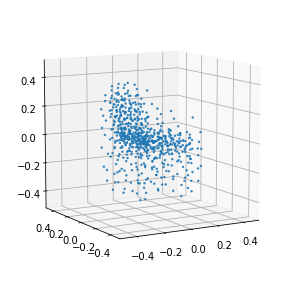

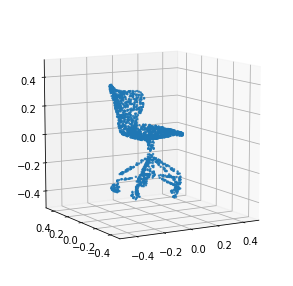

In [14]:
i = 3
plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);

plot_3d_point_cloud(feed_pc[i][:, 0], 
                    feed_pc[i][:, 1], 
                    feed_pc[i][:, 2], in_u_sphere=True);